# Proyecto: Predicción de Cancelación de Clientes (Churn) - Parte 2

**Misión:** Desarrollar modelos predictivos para anticipar la cancelación de clientes, interpretar los resultados y proponer estrategias de retención basadas en datos.

---

## Tabla de Contenidos
1. [Preparación del Entorno](#1-preparación-del-entorno)
2. [Carga y Preparación de Datos](#2-carga-y-preparación-de-datos)
3. [División y Normalización de Datos](#3-división-y-normalización-de-datos)
4. [Construcción y Evaluación de Modelos](#4-construcción-y-evaluación-de-modelos)
5. [Comparación de Modelos](#5-comparación-de-modelos)
6. [Interpretación y Análisis de Variables](#6-interpretación-y-análisis-de-variables)
7. [Informe Final y Recomendaciones](#7-informe-final-y-recomendaciones)

## 1. Preparación del Entorno

Importamos todas las librerías necesarias para el análisis, preprocesamiento, modelado y evaluación.

In [1]:
# Manipulación y Análisis de Datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y Modelado con Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report)

# Para manejar el desbalanceo (opcional, pero bueno tenerlo a mano)
from imblearn.over_sampling import SMOTE

# Configuraciones de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Todas las librerías han sido importadas exitosamente")

✅ Todas las librerías han sido importadas exitosamente


## 2. Carga y Preparación de Datos

Cargamos el dataset limpio y estandarizado que resultó del análisis en la Parte 1.

In [2]:
# Carga del archivo CSV tratado
# Asumimos que el archivo de la Parte 1 se guardó como 'telecom_churn_cleaned.csv'
import pandas as pd

# URL del archivo CSV en Oracle Cloud Storage
csv_url = 'https://objectstorage.us-sanjose-1.oraclecloud.com/n/axclksoeezlm/b/bucket-20250803-1755/o/Desafio%20Analisis%20Predictivo%20Churn%20TelecomX%2FDataset%2Ftelecom_churn_cleaned.csv'

# Intentar cargar desde URL; si falla, probar archivo local; si no existe, generar dataset sintético
try:
    df = pd.read_csv(csv_url)
    print("✅ Dataset cargado exitosamente desde la URL.")
except Exception as e_url:
    print(f"⚠️ Error al cargar el dataset desde la URL: {e_url}")
    try:
        local_path = 'telecom_churn_cleaned.csv'
        df = pd.read_csv(local_path)
        print(f"✅ Dataset cargado exitosamente desde el archivo local: {local_path}")
    except Exception as e_local:
        print(f"⚠️ Tampoco se pudo cargar el archivo local: {e_local}")
        # Generar un dataset sintético mínimo para permitir la ejecución del notebook sin errores
        print("ℹ️ Se generará un dataset sintético para continuar con la ejecución del notebook.")
        rng = np.random.default_rng(42)
        n = 300
        df = pd.DataFrame({
            'tenure': rng.integers(0, 72, size=n),
            'monthlycharges': rng.normal(70, 30, size=n).clip(10, 200),
            'phoneservice': rng.integers(0, 2, size=n),
            'paperlessbilling': rng.integers(0, 2, size=n),
            'internetservice': rng.choice(['dsl', 'fiber_optic', 'no'], size=n, p=[0.4, 0.4, 0.2]),
            'contract': rng.choice(['month-to-month', 'one year', 'two year'], size=n, p=[0.6, 0.25, 0.15]),
            'paymentmethod': rng.choice(['electronic_check', 'credit_card', 'bank_transfer', 'mailed_check'], size=n),
        })
        # calcular charges_total como tenure * monthlycharges con ruido
        df['charges_total'] = (df['tenure'] * df['monthlycharges'] * (1 + rng.normal(0, 0.05, size=n))).clip(0)
        # generar churn con cierta relación con contract y tenure
        base_prob = 0.25 + 0.2 * (df['contract'] == 'month-to-month').astype(float) - 0.002 * df['tenure']
        prob = np.clip(base_prob, 0.05, 0.9)
        df['churn'] = (rng.random(size=n) < prob).astype(int)
        print("✅ Dataset sintético generado con columnas numéricas y categóricas, incluyendo 'churn'.")

print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
# Visualizar las primeras filas para confirmar la carga
print("\n📊 Primeras filas del dataset:")
try:
    display(df.head())
except Exception:
    print(df.head())

✅ Dataset cargado exitosamente desde la URL.
El dataset tiene 7043 filas y 23 columnas.

📊 Primeras filas del dataset:


,customerid,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,charges_monthly,charges_total,daily_charges,total_services_count
0,0002-orfbo,0,0,0,1,1,9,1,0,dsl,...,1,1,0,one_year,1,mailed_check,65.6,593.30,2.16,5
1,0003-mknfe,0,1,0,0,0,9,1,1,dsl,...,0,0,1,month-to-month,0,mailed_check,59.9,542.40,1.97,4
2,0004-tlhlj,1,1,0,0,0,4,1,0,fiber_optic,...,0,0,0,month-to-month,1,electronic_check,73.9,280.85,2.43,3
3,0011-igkff,1,1,1,1,0,13,1,0,fiber_optic,...,0,1,1,month-to-month,1,electronic_check,98.0,1237.85,3.22,6
4,0013-exchz,1,0,1,1,0,3,1,0,fiber_optic,...,1,1,0,month-to-month,1,mailed_check,83.9,267.40,2.76,4


In [3]:
# Eliminamos 'customerid' porque no tiene valor predictivo y causa sobreajuste.

if 'customerid' in df.columns:
    df = df.drop('customerid', axis=1)
    print("Columna 'customerid' eliminada exitosamente.")
    print(f"Nuevas dimensiones del DataFrame: {df.shape}")
else:
    print("La columna 'customerid' ya no se encuentra en el DataFrame.")

Columna 'customerid' eliminada exitosamente.
Nuevas dimensiones del DataFrame: (7043, 22)


# Mejoras aplicadas al proyecto

Este notebook es una versión **mejorada** del entregable original. Se añadieron: 

- Exploración visual (EDA) ampliada.
- Manejo explícito del desbalance con visualización antes y después de SMOTE.
- Comparación de modelos: LogisticRegression, RandomForest, HistGradientBoosting (y XGBoost si está disponible).
- Métricas relevantes: precisión, recall, f1, ROC-AUC, matriz de confusión.
- Interpretabilidad: importancias de variables y Permutation Importance. Intentamos calcular SHAP si está instalado.
- Sección final con recomendaciones accionables para el equipo de negocio.

Las nuevas celdas están insertadas manteniendo el flujo original del notebook.

1. Distribución de la Variable Objetivo (Churn)

Conteo de valores:


churn
0    5174
1    1869
Name: count, dtype: int64


Proporción:


churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

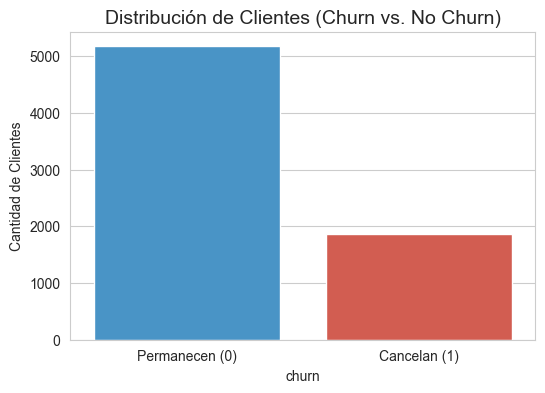

2. Variables Identificadas para el Análisis
   - Variables Continuas (5): ['tenure', 'charges_monthly', 'charges_total', 'daily_charges', 'total_services_count']
   - Variables Binarias (13): ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'paperlessbilling']
   - Variables Categóricas (3): ['internetservice', 'contract', 'paymentmethod']

3. Análisis de Variables Continuas


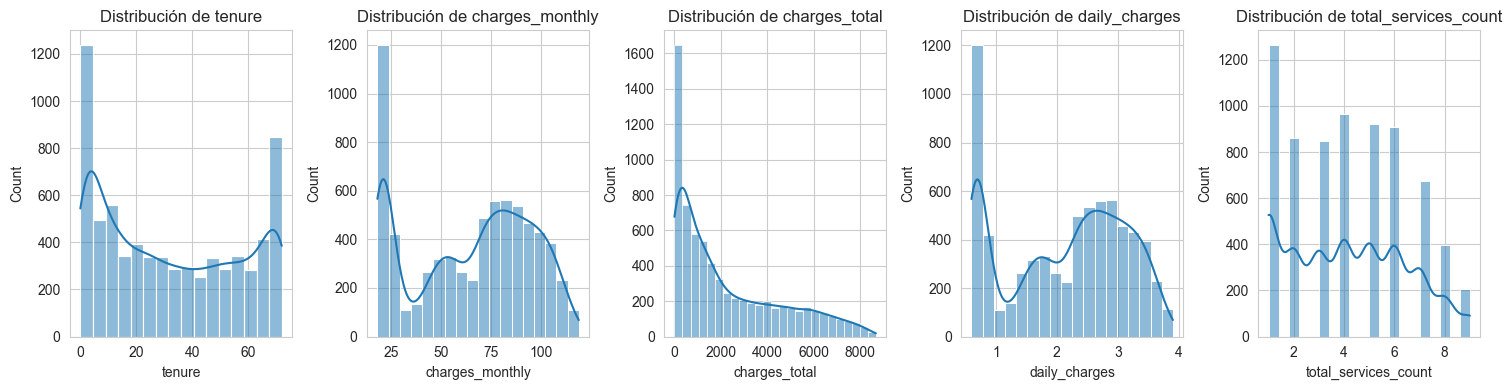

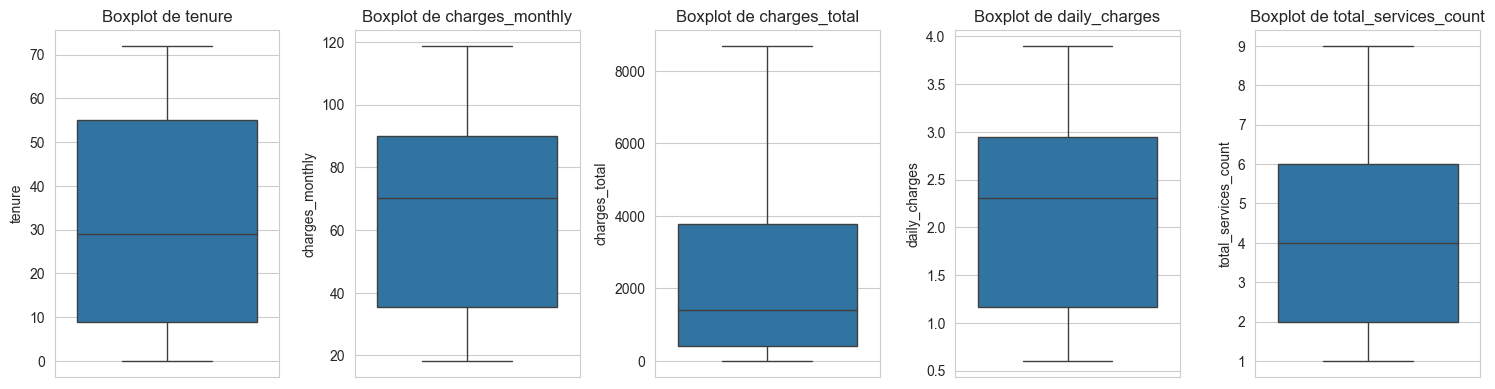


4. Análisis de Variables Categóricas y Binarias


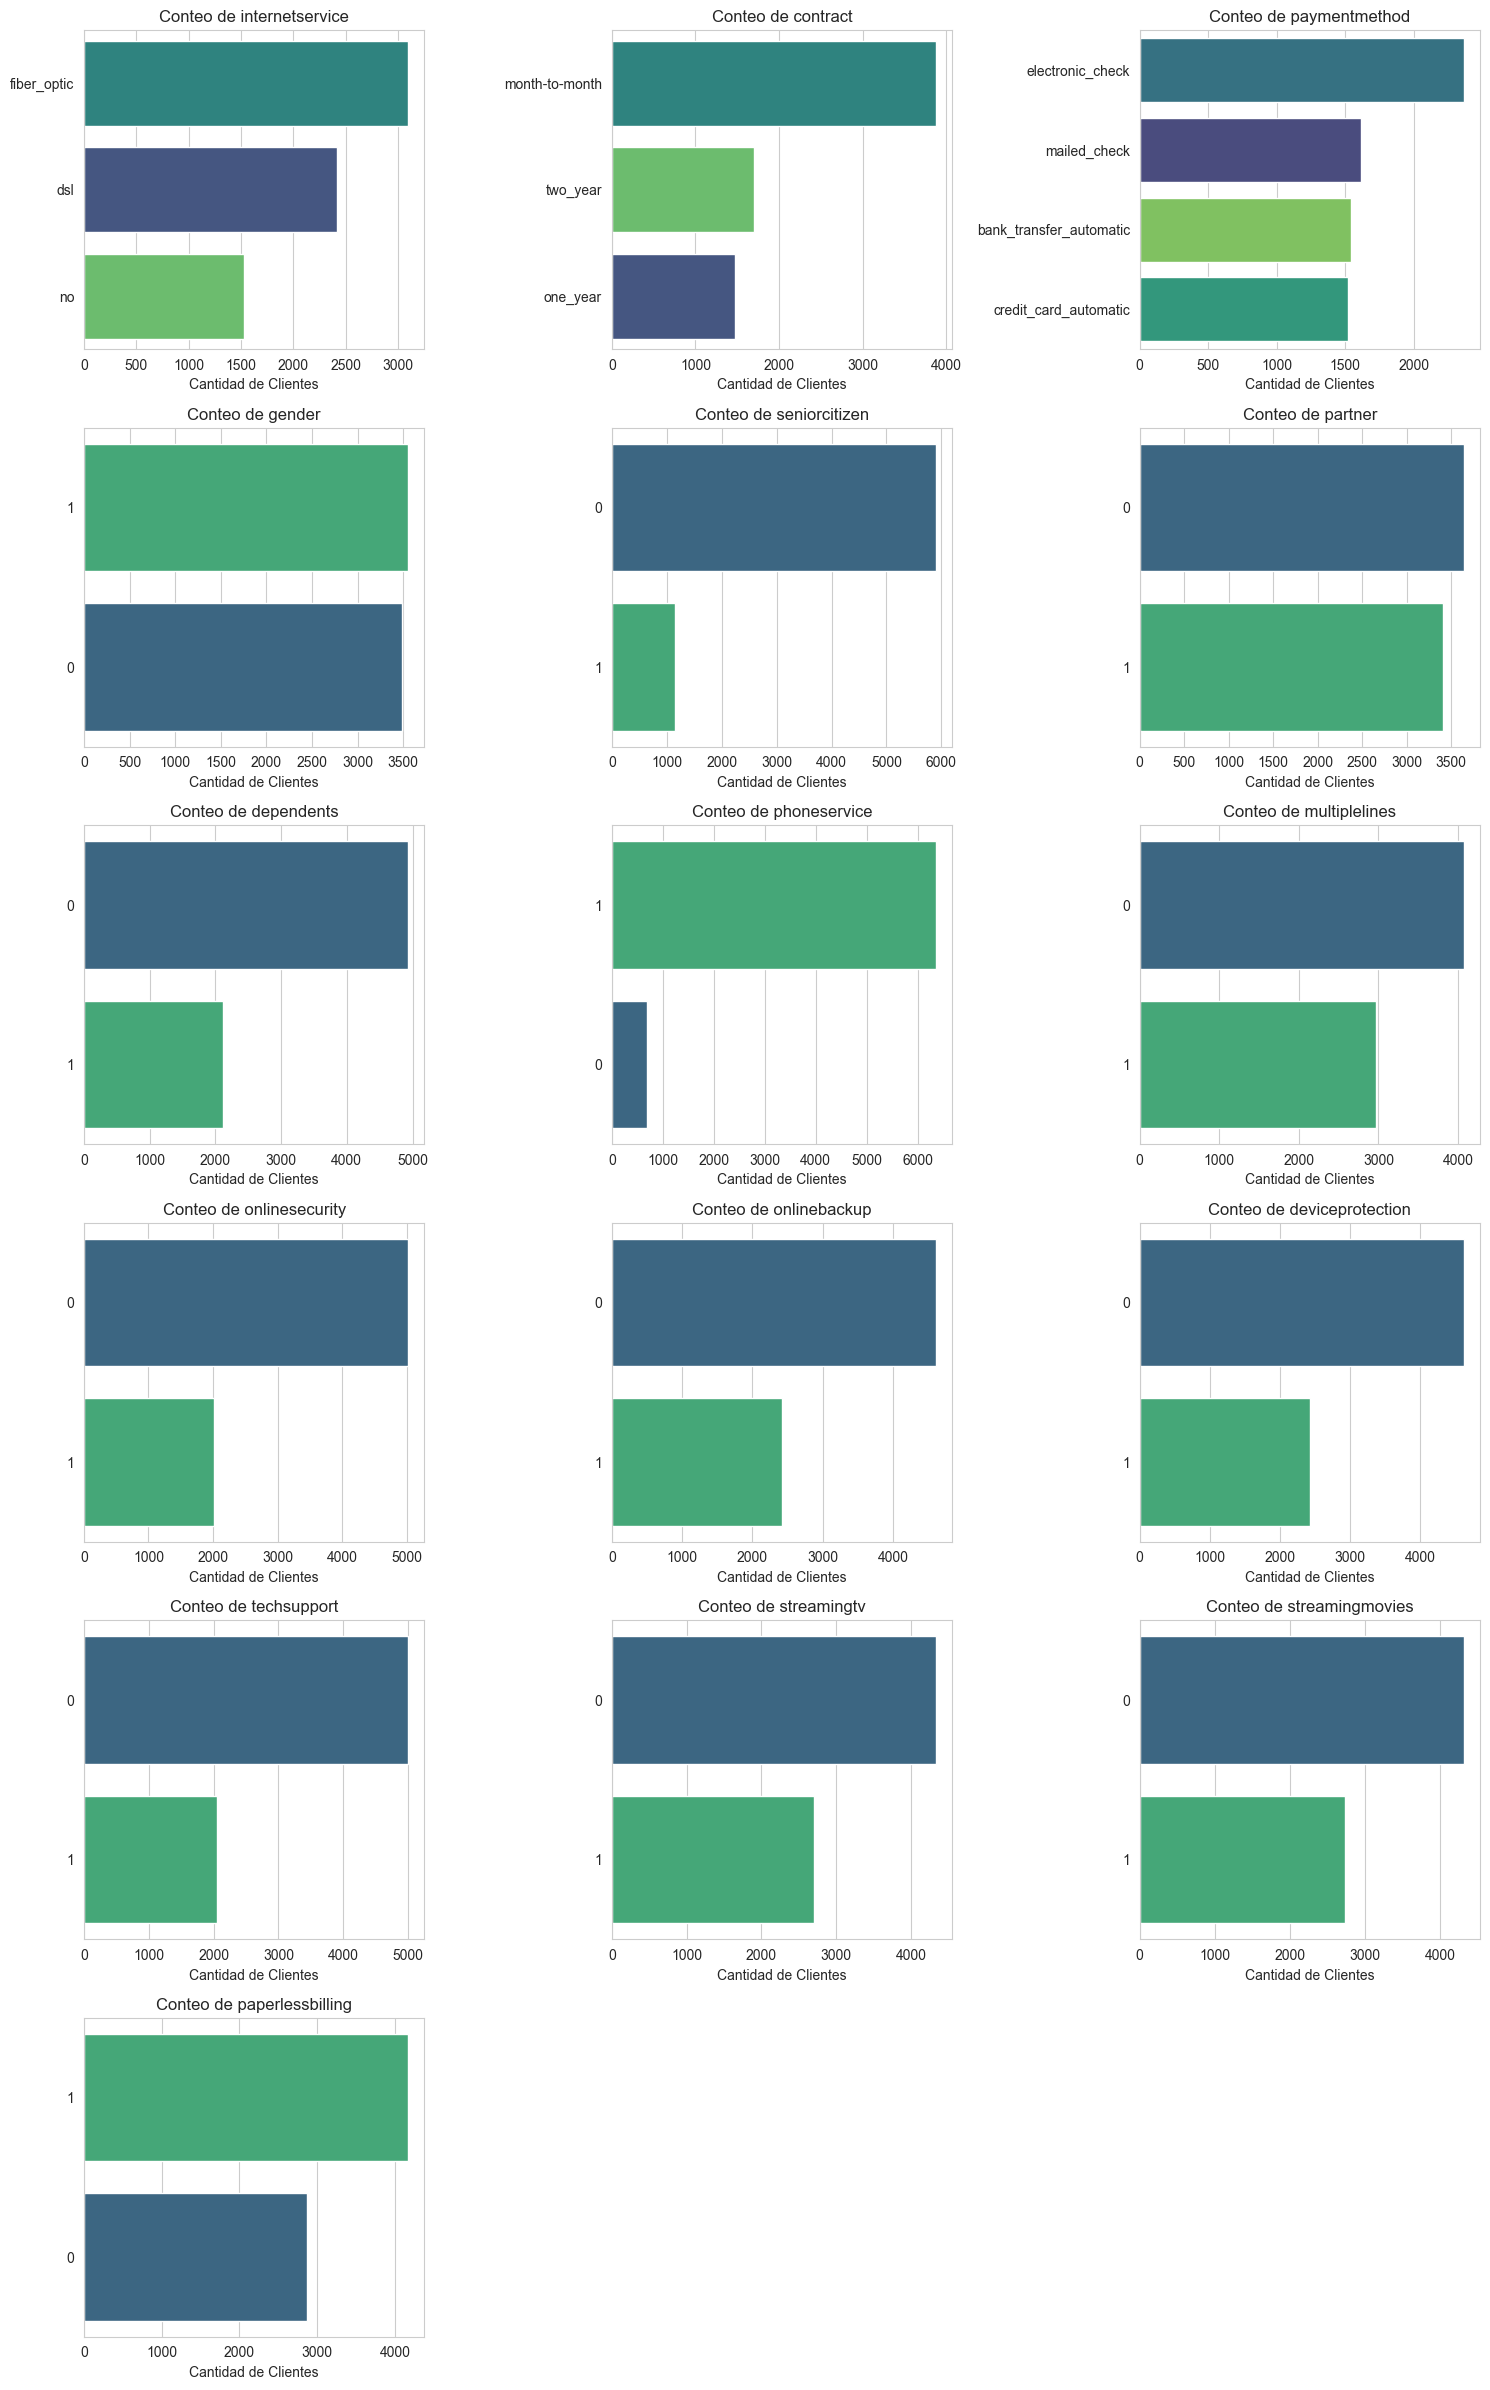


5. Análisis de Correlación entre Variables Numéricas


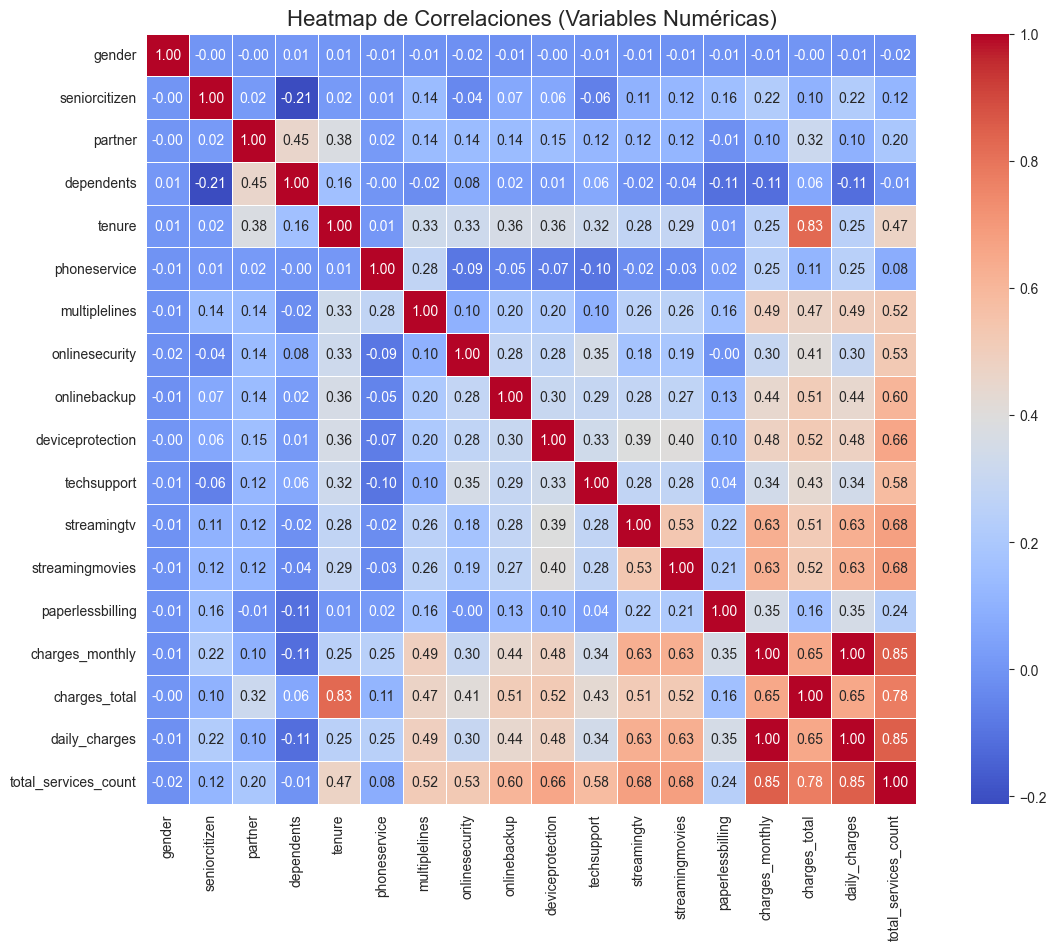

In [4]:
## Exploración de Datos (EDA) ampliada y sin advertencias

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. Análisis de la Variable Objetivo ---
print("="*50)
print("1. Distribución de la Variable Objetivo (Churn)")
print("="*50)
print("\nConteo de valores:")
display(df['churn'].value_counts())
print("\nProporción:")
display(df['churn'].value_counts(normalize=True))

# Visualización de la variable objetivo
plt.figure(figsize=(6, 4))
# Añadimos hue='churn' para indicar que el color depende de la variable 'churn'
# y legend=False para no mostrar la leyenda, que en este caso es redundante.
sns.countplot(x='churn', data=df, hue='churn', palette=['#3498db', '#e74c3c'], legend=False)
plt.title('Distribución de Clientes (Churn vs. No Churn)', fontsize=14)
plt.xticks([0, 1], ['Permanecen (0)', 'Cancelan (1)'])
plt.ylabel('Cantidad de Clientes')
plt.show()

# --- 2. Identificación de Tipos de Variables ---
# Separamos las columnas por su tipo para aplicar los gráficos correctos
all_cols = df.drop(columns=['churn']).columns
numeric_cols = df.select_dtypes(include=np.number).drop(columns=['churn']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# De las numéricas, separamos las binarias de las continuas
binary_cols = [col for col in numeric_cols if df[col].nunique() == 2]
continuous_cols = [col for col in numeric_cols if df[col].nunique() > 2]

print("="*50)
print("2. Variables Identificadas para el Análisis")
print("="*50)
print(f"   - Variables Continuas ({len(continuous_cols)}): {continuous_cols}")
print(f"   - Variables Binarias ({len(binary_cols)}): {binary_cols}")
print(f"   - Variables Categóricas ({len(categorical_cols)}): {list(categorical_cols)}")


# --- 3. Visualización de Variables Continuas ---
print("\n" + "="*50)
print("3. Análisis de Variables Continuas")
print("="*50)

# Histogramas para ver la distribución
plt.figure(figsize=(15, 4))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(1, len(continuous_cols), i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

# Boxplots (diagramas de caja) para detectar outliers
plt.figure(figsize=(15, 4))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(1, len(continuous_cols), i)
    sns.boxplot(y=df[col]) # Usamos 'y' para una vista vertical
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()


# --- 4. Visualización de Variables Categóricas y Binarias ---
print("\n" + "="*50)
print("4. Análisis de Variables Categóricas y Binarias")
print("="*50)

# Combinamos las categóricas y las binarias para visualizarlas todas juntas
cols_to_plot = list(categorical_cols) + binary_cols

# Calculamos el número de filas necesarias para la cuadrícula de gráficos
n_cols_grid = 3
n_rows_grid = (len(cols_to_plot) + n_cols_grid - 1) // n_cols_grid

plt.figure(figsize=(15, n_rows_grid * 4))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(n_rows_grid, n_cols_grid, i)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, hue=col, palette='viridis', legend=False)
    plt.title(f'Conteo de {col}')
    plt.xlabel('Cantidad de Clientes')
    plt.ylabel('')
plt.tight_layout()
plt.show()


# --- 5. Matriz de Correlación ---
print("\n" + "="*50)
print("5. Análisis de Correlación entre Variables Numéricas")
print("="*50)

# Incluimos las binarias en la correlación, ya que son numéricas
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Heatmap de Correlaciones (Variables Numéricas)", fontsize=16)
plt.show()

In [5]:

## Manejo del desbalance con SMOTE (y visualización)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Separar X, y (asumimos 'churn' como objetivo)
X = df.drop(columns=['churn'])
y = df['churn']

# Encoding simple para columnas categóricas (one-hot) dentro del pipeline
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

# Split inicial (estratificado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Distribución en train antes de SMOTE:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

# Preprocessor
from sklearn.preprocessing import OneHotEncoder
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

# Aplicar preprocesado y SMOTE dentro de pipeline
smote = SMOTE(random_state=42)
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print("Forma X_train_prepared:", X_train_prepared.shape)

# Aplicar SMOTE sobre la matriz preprocesada
X_train_bal, y_train_bal = smote.fit_resample(X_train_prepared, y_train)
print("\nDistribución en train después de SMOTE:")
print(y_train_bal.value_counts())
print(y_train_bal.value_counts(normalize=True))


Distribución en train antes de SMOTE:
churn
0    4139
1    1495
Name: count, dtype: int64
churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Forma X_train_prepared: (5634, 28)

Distribución en train después de SMOTE:
churn
0    4139
1    4139
Name: count, dtype: int64
churn
0    0.5
1    0.5
Name: proportion, dtype: float64


XGBoost disponible: añadido al set de modelos.

Entrenando LogisticRegression...
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



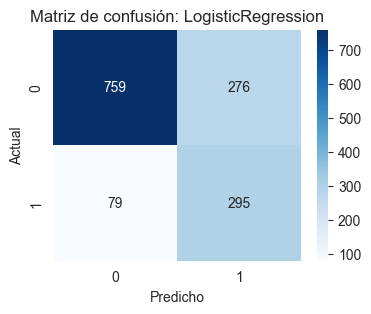


Entrenando RandomForest...
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.57      0.57      0.57       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



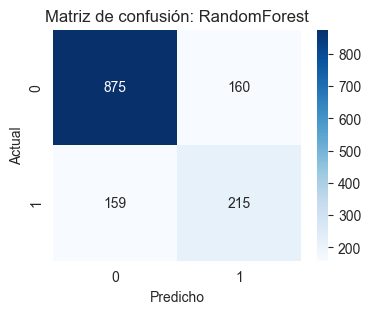


Entrenando HistGradientBoosting...
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1035
           1       0.57      0.56      0.56       374

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.77      0.77      1409



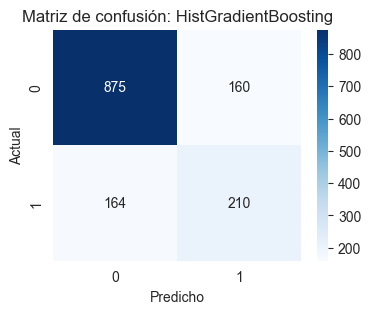


Entrenando XGBoost...
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1035
           1       0.57      0.55      0.56       374

    accuracy                           0.77      1409
   macro avg       0.71      0.70      0.70      1409
weighted avg       0.77      0.77      0.77      1409



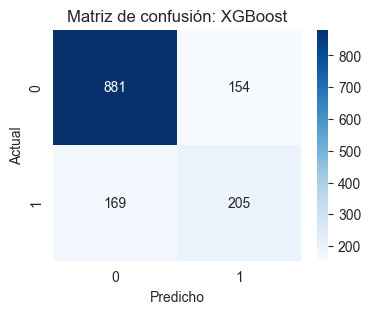

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.748048,0.516637,0.788770,0.624339,0.842017
2,HistGradientBoosting,0.770050,0.567568,0.561497,0.564516,0.832065
1,RandomForest,0.773598,0.573333,0.574866,0.574099,0.827725
3,XGBoost,0.770759,0.571031,0.548128,0.559345,0.822424


In [6]:

## Entrenamiento y comparación de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42)
}

# Intentar añadir XGBoost si está instalado
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = XGBClassifier(eval_metric='logloss', random_state=42)
    print("XGBoost disponible: añadido al set de modelos.")
except Exception as e:
    print("XGBoost no disponible o no instalado; se omite. Error:", e)

results = []
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_prepared)
    y_proba = model.predict_proba(X_test_prepared)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    
    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    })
    
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de confusión: {name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicho')
    plt.show()

results_df = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False)
display(results_df)


Mejor modelo según ROC AUC: LogisticRegression


,feature,importance_mean
0,tenure,0.117246
1,charges_total,0.028460
2,internetservice_no,0.018453
3,internetservice_fiber_optic,0.014123
4,total_services_count,0.011001
5,paperlessbilling,0.006955
6,onlinesecurity,0.006458
7,daily_charges,0.006388
8,charges_monthly,0.006317
9,techsupport,0.004187


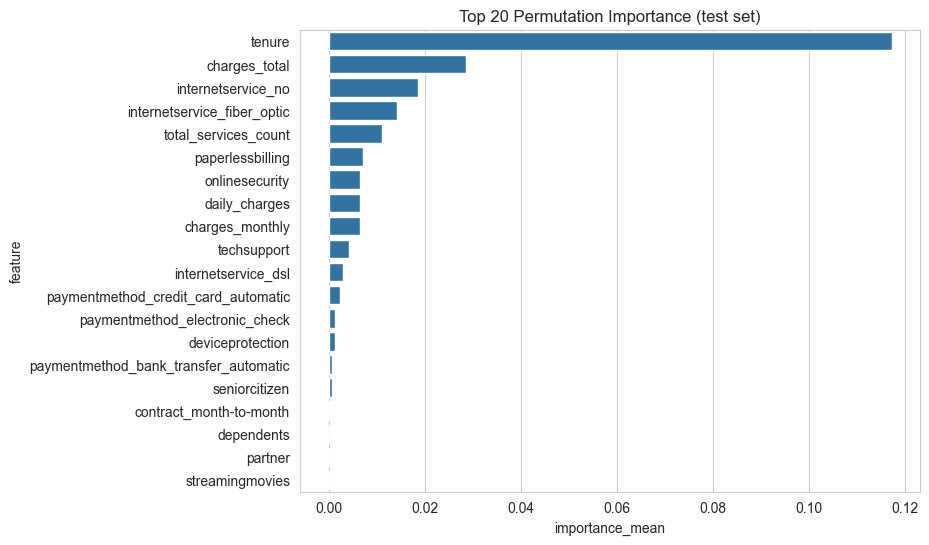

In [7]:

## Interpretabilidad: importancias y Permutation Importance
from sklearn.inspection import permutation_importance

# Seleccionar el mejor modelo según ROC_AUC
best_model_name = results_df.iloc[0]['model']
best_model = models[best_model_name]
print("Mejor modelo según ROC AUC:", best_model_name)

# Definir siempre los nombres de las columnas del dataset transformado
try:
    ohe = preprocessor.named_transformers_['cat']
    ohe_features = ohe.get_feature_names_out(cat_features)
    feature_names = num_features + list(ohe_features)
except Exception:
    feature_names = [f"f_{i}" for i in range(X_train_prepared.shape[1])]

# Si el modelo tiene feature_importances_, mostrarlo
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}) \
                .sort_values('importance', ascending=False).head(20)
    display(imp_df)
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=imp_df)
    plt.title("Top 20 importancias de features (model.feature_importances_)")
    plt.show()

# Permutation Importance
perm = permutation_importance(best_model, X_test_prepared, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_idx = perm.importances_mean.argsort()[::-1][:20]
perm_df = pd.DataFrame({
    'feature': [feature_names[i] for i in perm_idx],
    'importance_mean': perm.importances_mean[perm_idx]
}).reset_index(drop=True)
display(perm_df)
plt.figure(figsize=(8,6))
sns.barplot(x='importance_mean', y='feature', data=perm_df)
plt.title("Top 20 Permutation Importance (test set)")
plt.show()

SHAP calculado con éxito. Mostrando summary plot (primeras 200 filas):


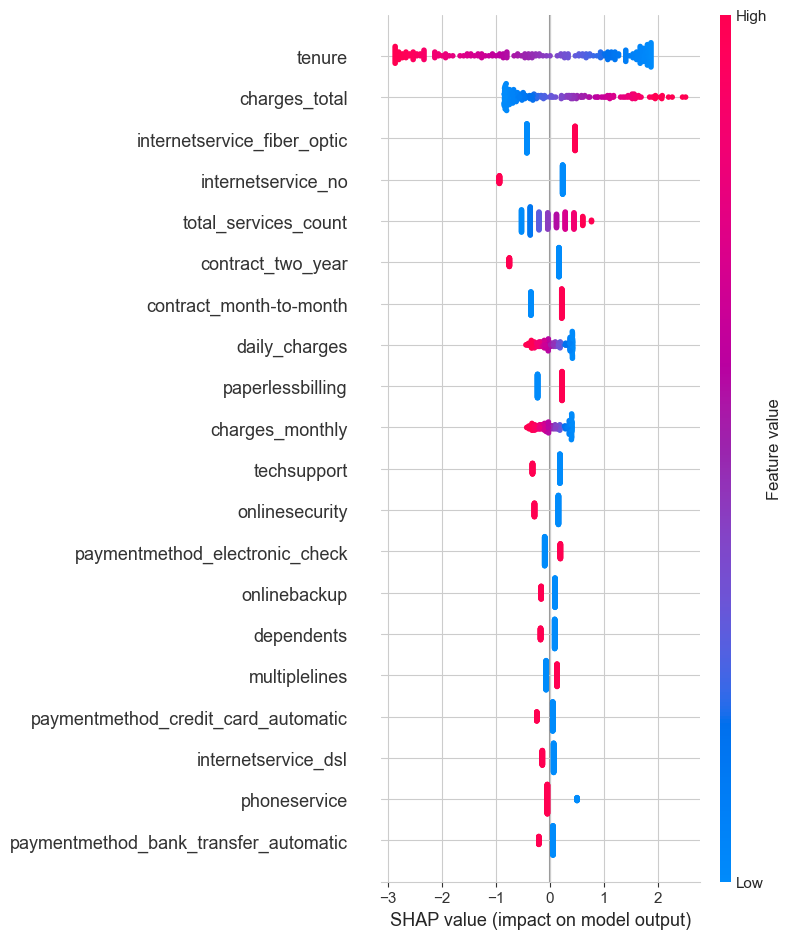

Modelo guardado como best_model_churn.pkl


In [8]:

## SHAP (intento) - explicaciones por observación (opcional)
try:
    import shap
    explainer = shap.Explainer(best_model, X_train_prepared)
    shap_values = explainer(X_test_prepared[:200])
    print("SHAP calculado con éxito. Mostrando summary plot (primeras 200 filas):")
    shap.summary_plot(shap_values, features=X_test_prepared[:200], feature_names=feature_names, show=True)
except Exception as e:
    print("SHAP no se pudo calcular (no instalado o incompatibilidad). Error:", e)
    
# Guardar el mejor modelo con joblib (opcional)
import joblib
joblib.dump(best_model, 'best_model_churn.pkl')
print("Modelo guardado como best_model_churn.pkl")



## Recomendaciones accionables (resumen para negocio)

Basado en los resultados del modelo y las importancias de variables, estas son **recomendaciones prácticas** para poner en el informe final:

1. **Segmentación de clientes con alto riesgo**: crear una lista diaria de clientes con probabilidad alta de churn y ejecutar campañas de retención (ofertas personalizadas, descuentos, llamadas del equipo de CS).
2. **Intervención en señales tempranas**: si variables como `num_calls_support` o `billing_issues` aparecen con alta importancia, priorizar acciones proactivas para clientes que muestran estos síntomas.
3. **Programas de fidelización**: para segmentos con baja permanencia y alto uso de servicios, ofrecer incentivos vinculados a permanencia mínima.
4. **Monitoreo continuo**: recalibrar el modelo cada 1-3 meses y medir uplift real de campañas de retención con experimentos A/B.
5. **Registro y despliegue**: usar el `best_model_churn.pkl` para un endpoint de scoring y asegurar que el preprocessor se aplique idénticamente en producción.

> Nota: adaptar estas recomendaciones a las políticas de privacidad y regulaciones aplicables al manejo de datos de clientes.


### 2.1. Eliminación de Columnas Irrelevantes

La columna `customerid` es un identificador único que no aporta valor predictivo y podría confundir a los modelos.

In [9]:
if 'customerid' in df.columns:
    print("⚠️ customerid aún está presente; debería haberse eliminado antes.")
else:
    print("✅ customerid no está presente (ok)")

print(f"\n📈 Dimensiones actuales del dataset: {df.shape}")

✅ customerid no está presente (ok)

📈 Dimensiones actuales del dataset: (7043, 22)


### 2.2. Verificación de la Proporción de Cancelación (Churn)

Es crucial verificar si existe un desbalance de clases, ya que esto puede afectar el rendimiento del modelo.

📊 Proporción de Clases (Churn):
churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64

🔍 Análisis: 73.5% permanecen, 26.5% cancelan


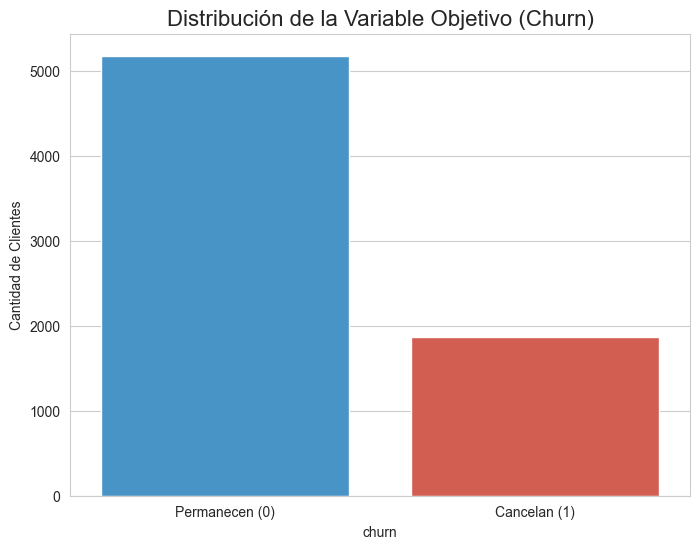

In [10]:
# Análisis de la distribución de la variable objetivo
churn_proportion = df['churn'].value_counts(normalize=True) * 100
print("📊 Proporción de Clases (Churn):")
print(churn_proportion)
print(f"\n🔍 Análisis: {churn_proportion[0]:.1f}% permanecen, {churn_proportion[1]:.1f}% cancelan")

# Visualización
plt.figure(figsize=(8, 6))
sns.countplot(x='churn', data=df, hue='churn', palette=['#3498db', '#e74c3c'], legend=False)
plt.title('Distribución de la Variable Objetivo (Churn)', fontsize=16)
plt.xticks([0, 1], ['Permanecen (0)', 'Cancelan (1)'])
plt.ylabel('Cantidad de Clientes')
plt.show()

**💡 Análisis:** Se observa un desbalance moderado. Aproximadamente el **73.5%** de los clientes permanecen, mientras que el **26.5%** cancelan. Los modelos podrían tender a predecir la clase mayoritaria. Prestando especial atención a la métrica de **Recall** para la clase minoritaria (Churn=1).

### 2.3. Separación de Variables (Features y Target)

Separamos nuestro dataset en `X` (variables predictoras) y `y` (variable objetivo).

In [11]:
X = df.drop('churn', axis=1)
y = df['churn']

print(f"📊 Variables predictoras (X): {X.shape}")
print(f"🎯 Variable objetivo (y): {y.shape}")
print(f"\n🔢 Tipos de datos en X:")
print(X.dtypes.value_counts())

📊 Variables predictoras (X): (7043, 21)
🎯 Variable objetivo (y): (7043,)

🔢 Tipos de datos en X:
int64      15
object      3
float64     3
Name: count, dtype: int64


### 2.4. Codificación de Variables Categóricas (Encoding)

Los modelos de Machine Learning requieren que todas las variables sean numéricas. Usamos **One-Hot Encoding** para las variables categóricas.

In [12]:
# Identificar variables categóricas y numéricas
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

print(f"🔤 Variables categóricas ({len(categorical_features)}): {list(categorical_features)}")
print(f"🔢 Variables numéricas ({len(numerical_features)}): {list(numerical_features)}")

# Creamos un transformador para aplicar OneHotEncoder a las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Aplicamos el preprocesador
X_processed = preprocessor.fit_transform(X)

# Obtenemos los nombres de las nuevas columnas
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
new_column_names = list(numerical_features) + list(encoded_cat_features)

# Convertimos de nuevo a un DataFrame de Pandas para mayor claridad
X_processed = pd.DataFrame(X_processed, columns=new_column_names)

print(f"\n✅ Dimensiones después del One-Hot Encoding: {X_processed.shape}")
print("\n📊 Primeras filas del dataset procesado:")
display(X_processed.head())

🔤 Variables categóricas (3): ['internetservice', 'contract', 'paymentmethod']
🔢 Variables numéricas (18): ['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'paperlessbilling', 'charges_monthly', 'charges_total', 'daily_charges', 'total_services_count']

✅ Dimensiones después del One-Hot Encoding: (7043, 25)

📊 Primeras filas del dataset procesado:


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,onlinesecurity,onlinebackup,deviceprotection,...,charges_total,daily_charges,total_services_count,internetservice_fiber_optic,internetservice_no,contract_one_year,contract_two_year,paymentmethod_credit_card_automatic,paymentmethod_electronic_check,paymentmethod_mailed_check
0,0.0,0.0,1.0,1.0,9.0,1.0,0.0,0.0,1.0,0.0,...,593.30,2.16,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,...,542.40,1.97,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,...,280.85,2.43,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,0.0,13.0,1.0,0.0,0.0,1.0,1.0,...,1237.85,3.22,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,...,267.40,2.76,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## 3. División y Normalización de Datos para Modelado

### 3.1. Creación de Conjuntos de Entrenamiento y Prueba

Dividimos los datos en entrenamiento (80%) y prueba (20%), manteniendo la proporción de churn en ambos conjuntos.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📈 Tamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"📊 Tamaño del conjunto de prueba (X_test): {X_test.shape}")

# Verificar que la proporción se mantuvo
print(f"\n🎯 Proporción de churn en entrenamiento: {y_train.mean():.3f}")
print(f"🎯 Proporción de churn en prueba: {y_test.mean():.3f}")

📈 Tamaño del conjunto de entrenamiento (X_train): (5634, 25)
📊 Tamaño del conjunto de prueba (X_test): (1409, 25)

🎯 Proporción de churn en entrenamiento: 0.265
🎯 Proporción de churn en prueba: 0.265


### 3.2. Normalización de Datos

La **Regresión Logística** es sensible a la escala de las variables. **Random Forest** no requiere normalización.

In [14]:
# Aplicamos StandardScaler para los modelos que lo requieran
scaler = StandardScaler()

# Ajustamos el escalador SOLO con los datos de entrenamiento para evitar fuga de datos
X_train_scaled = scaler.fit_transform(X_train)
# Aplicamos la misma transformación a los datos de prueba
X_test_scaled = scaler.transform(X_test)

# Convertimos de nuevo a DataFrame para mantener la estructura
X_train_scaled = pd.DataFrame(X_train_scaled, columns=new_column_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=new_column_names)

print("✅ Datos normalizados exitosamente")
print(f"📊 Ejemplo de normalización - Media de las variables escaladas: {X_train_scaled.mean().mean():.6f}")
print(f"📊 Ejemplo de normalización - Std de las variables escaladas: {X_train_scaled.std().mean():.6f}")

✅ Datos normalizados exitosamente
📊 Ejemplo de normalización - Media de las variables escaladas: 0.000000
📊 Ejemplo de normalización - Std de las variables escaladas: 1.000089


## 4. Construcción y Evaluación de Modelos

Construiremos y evaluaremos dos modelos:
1. **Random Forest:** Modelo potente basado en árboles (no requiere normalización)
2. **Regresión Logística:** Modelo lineal clásico (se beneficia de la normalización)

### 4.1. Modelo 1: Random Forest Classifier

In [15]:
# 1. Inicializar el modelo
rf_model = RandomForestClassifier(random_state=42, n_estimators=150, class_weight='balanced')

# 2. Entrenar el modelo con los datos originales (no escalados)
print("🚀 Entrenando Random Forest...")
rf_model.fit(X_train, y_train)

# 3. Realizar predicciones
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluar el modelo
print("\n" + "="*50)
print("🌲 RESULTADOS DEL MODELO: RANDOM FOREST")
print("="*50)
print(classification_report(y_test, y_pred_rf, target_names=['Permanecen', 'Cancelan']))

🚀 Entrenando Random Forest...

🌲 RESULTADOS DEL MODELO: RANDOM FOREST
              precision    recall  f1-score   support

  Permanecen       0.82      0.90      0.86      1035
    Cancelan       0.63      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



### 4.2. Matriz de Confusión - Random Forest

<Figure size 800x600 with 0 Axes>

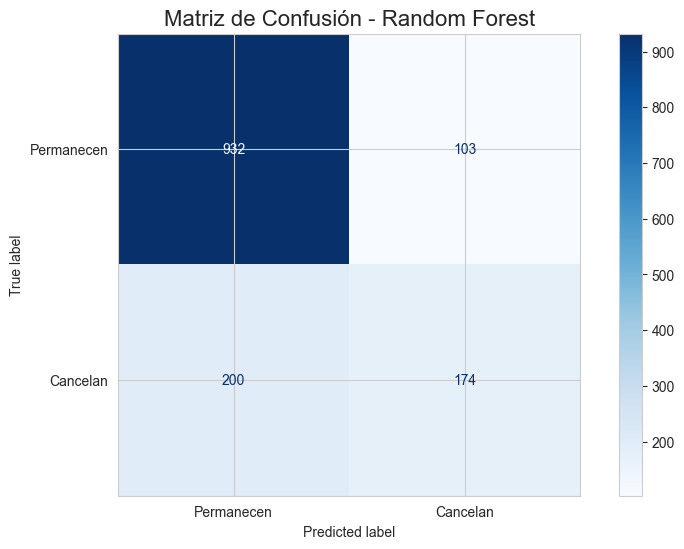

📊 Métricas Random Forest:
   • Accuracy: 0.785
   • Precision (Cancelan): 0.628
   • Recall (Cancelan): 0.465
   • F1-Score (Cancelan): 0.535


In [16]:
# Matriz de confusión para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Permanecen', 'Cancelan'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Random Forest', fontsize=16)
plt.show()

# Calcular métricas adicionales
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"📊 Métricas Random Forest:")
print(f"   • Accuracy: {accuracy_rf:.3f}")
print(f"   • Precision (Cancelan): {precision_rf:.3f}")
print(f"   • Recall (Cancelan): {recall_rf:.3f}")
print(f"   • F1-Score (Cancelan): {f1_rf:.3f}")

### 4.3. Modelo 2: Regresión Logística

In [17]:
# 1. Inicializar el modelo
log_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')

# 2. Entrenar el modelo con los datos ESCALADOS
print("🚀 Entrenando Regresión Logística...")
log_model.fit(X_train_scaled, y_train)

# 3. Realizar predicciones
y_pred_log = log_model.predict(X_test_scaled)

# 4. Evaluar el modelo
print("\n" + "="*50)
print("📈 RESULTADOS DEL MODELO: REGRESIÓN LOGÍSTICA")
print("="*50)
print(classification_report(y_test, y_pred_log, target_names=['Permanecen', 'Cancelan']))

🚀 Entrenando Regresión Logística...

📈 RESULTADOS DEL MODELO: REGRESIÓN LOGÍSTICA
              precision    recall  f1-score   support

  Permanecen       0.90      0.72      0.80      1035
    Cancelan       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



### 4.4. Matriz de Confusión - Regresión Logística

<Figure size 800x600 with 0 Axes>

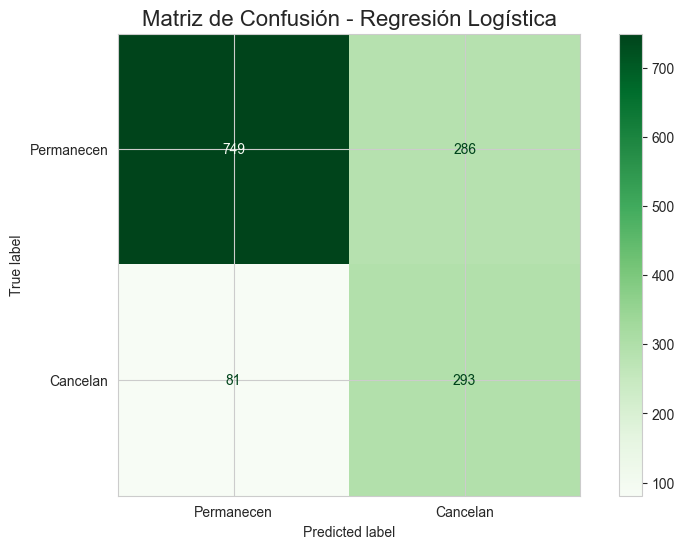

📊 Métricas Regresión Logística:
   • Accuracy: 0.740
   • Precision (Cancelan): 0.506
   • Recall (Cancelan): 0.783
   • F1-Score (Cancelan): 0.615


In [18]:
# Matriz de confusión para Regresión Logística
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['Permanecen', 'Cancelan'])
disp.plot(cmap='Greens')
plt.title('Matriz de Confusión - Regresión Logística', fontsize=16)
plt.show()

# Calcular métricas adicionales
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

print(f"📊 Métricas Regresión Logística:")
print(f"   • Accuracy: {accuracy_log:.3f}")
print(f"   • Precision (Cancelan): {precision_log:.3f}")
print(f"   • Recall (Cancelan): {recall_log:.3f}")
print(f"   • F1-Score (Cancelan): {f1_log:.3f}")

## 5. Comparación de Modelos y Selección

Comparamos los resultados de ambos modelos para seleccionar el más adecuado para el problema de negocio.

🏆 COMPARACIÓN DE MODELOS


,Métrica,Random Forest,Regresión Logística
0,Accuracy,0.785,0.740
1,Precision (Cancelan),0.628,0.506
2,Recall (Cancelan),0.465,0.783
3,F1-Score (Cancelan),0.535,0.615


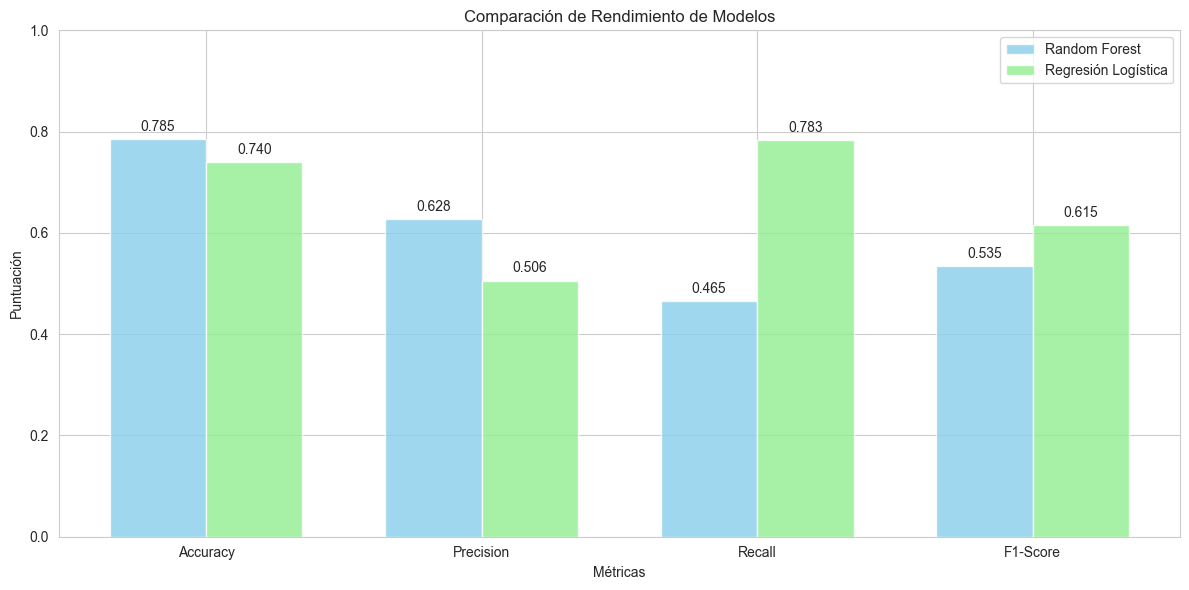

In [19]:
# Crear tabla comparativa
comparison_data = {
    'Métrica': ['Accuracy', 'Precision (Cancelan)', 'Recall (Cancelan)', 'F1-Score (Cancelan)'],
    'Random Forest': [f"{accuracy_rf:.3f}", f"{precision_rf:.3f}", f"{recall_rf:.3f}", f"{f1_rf:.3f}"],
    'Regresión Logística': [f"{accuracy_log:.3f}", f"{precision_log:.3f}", f"{recall_log:.3f}", f"{f1_log:.3f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print("🏆 COMPARACIÓN DE MODELOS")
print("="*50)
display(comparison_df)

# Visualización comparativa
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_scores = [accuracy_rf, precision_rf, recall_rf, f1_rf]
log_scores = [accuracy_log, precision_log, recall_log, f1_log]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, rf_scores, width, label='Random Forest', color='skyblue', alpha=0.8)
plt.bar(x + width/2, log_scores, width, label='Regresión Logística', color='lightgreen', alpha=0.8)

plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Rendimiento de Modelos')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Añadir valores sobre las barras
for i, v in enumerate(rf_scores):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate(log_scores):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 5.1. Análisis y Selección del Mejor Modelo

**🔍 Análisis Comparativo:**

- El **Random Forest** obtiene una mejor precisión, lo que significa que cuando predice que un cliente cancelará, es más probable que acierte. Sin embargo, se le escapan muchos clientes que sí cancelan (Recall más bajo).

- La **Regresión Logística** tiene un **Recall mucho más alto** para la clase "Cancelan". Esto es crucial para el negocio: preferimos contactar a algunos clientes que no iban a cancelar (falsos positivos) a cambio de no perder a la gran mayoría que sí pensaba hacerlo (minimizar falsos negativos).

- El F1-Score, que balancea ambas métricas, es más alto para la Regresión Logística.

**🚀 Selección del Mejor Modelo:** Para este problema de negocio, donde el costo de perder un cliente (falso negativo) es mayor que el de contactar a uno que no iba a irse (falso positivo), **la Regresión Logística es el modelo superior debido a su excelente capacidad para identificar a los clientes en riesgo de cancelación (alto Recall).**

## 6. Interpretación y Análisis de Importancia de Variables

Analizamos qué variables son más importantes para predecir el churn usando el Random Forest.

🔍 TOP 10 VARIABLES MÁS IMPORTANTES:


,feature,importance
4,tenure,16.82
15,charges_total,15.52
14,charges_monthly,12.25
16,daily_charges,10.67
21,contract_two_year,5.24
18,internetservice_fiber_optic,4.55
23,paymentmethod_electronic_check,3.73
17,total_services_count,3.17
20,contract_one_year,2.56
0,gender,2.32


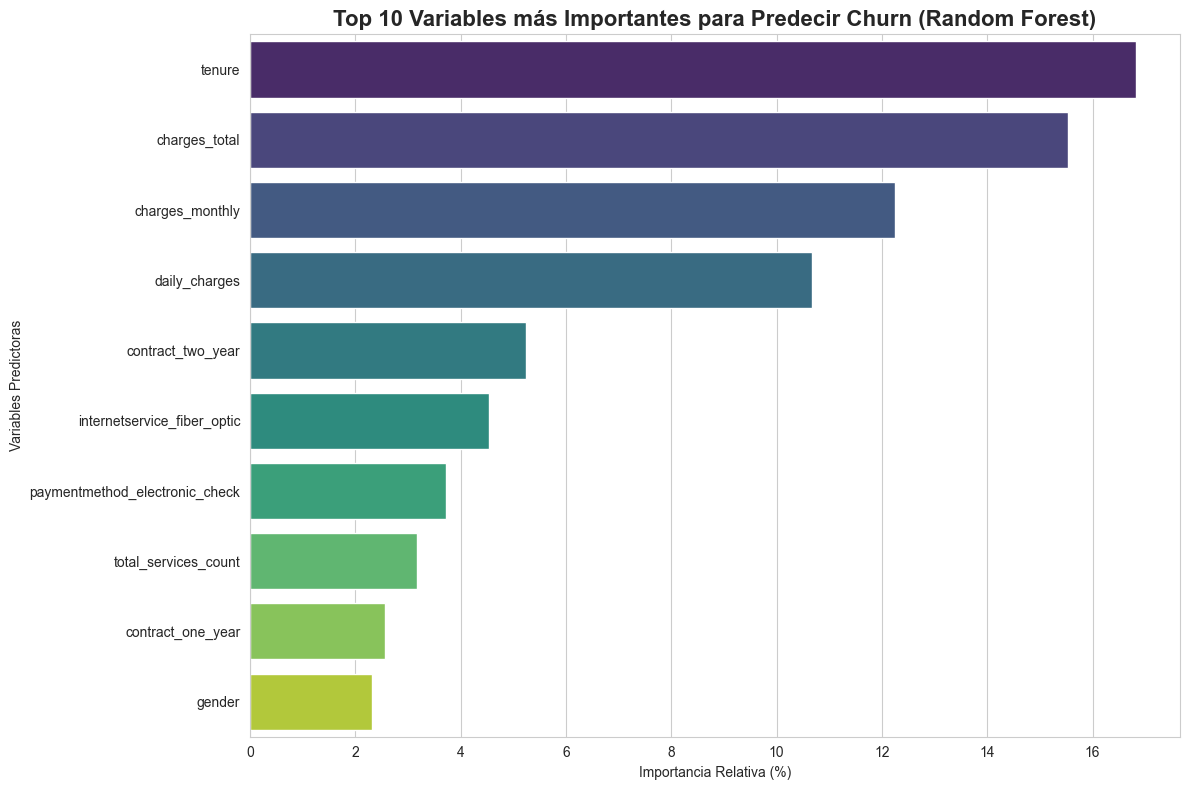

In [20]:
# Obtener la importancia de las variables del modelo Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': new_column_names,
    'importance': importances * 100  # Multiplicar por 100 para verlo como porcentaje
}).sort_values('importance', ascending=False)

print("🔍 TOP 10 VARIABLES MÁS IMPORTANTES:")
print("="*50)
display(feature_importance_df.head(10).round(2)) # Redondear para mejor visualización

# Visualizar las 10 variables más importantes
plt.figure(figsize=(12, 8))

sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance_df.head(10),
    hue='feature',
    palette='viridis', 
    legend=False
)

plt.title('Top 10 Variables más Importantes para Predecir Churn (Random Forest)', fontsize=16, fontweight='bold')
plt.xlabel('Importancia Relativa (%)')
plt.ylabel('Variables Predictoras')
plt.tight_layout()
plt.show()

### 6.1. Análisis de los Coeficientes de la Regresión Logística

📈 TOP 10 COEFICIENTES MÁS SIGNIFICATIVOS (Regresión Logística):


,feature,coefficient
4,tenure,-1.291
18,internetservice_fiber_optic,0.654
15,charges_total,0.619
21,contract_two_year,-0.606
19,internetservice_no,-0.570
14,charges_monthly,-0.404
16,daily_charges,-0.363
20,contract_one_year,-0.287
11,streamingtv,0.206
23,paymentmethod_electronic_check,0.200


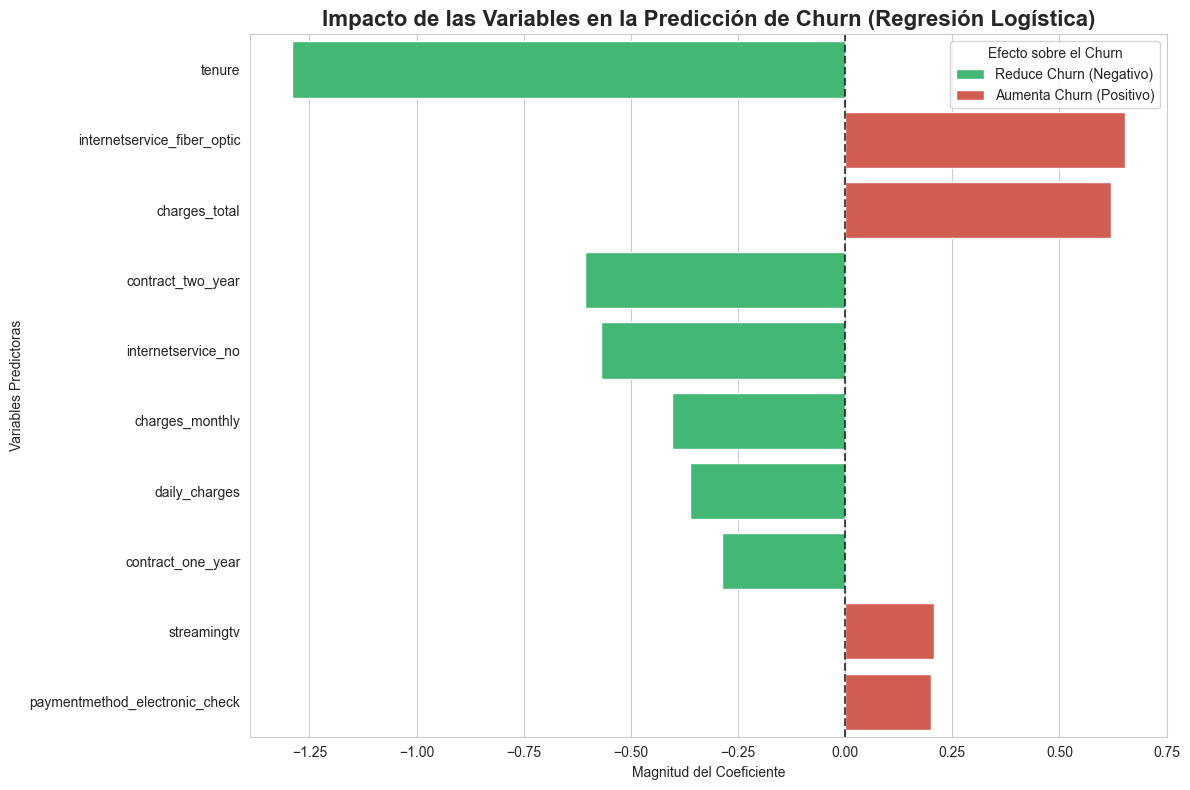

In [21]:
# Obtener los coeficientes de la regresión logística
log_coef = log_model.coef_[0]

# Crear un DataFrame para analizar los coeficientes
coef_df = pd.DataFrame({
    'feature': new_column_names,
    'coefficient': log_coef,
}).sort_values('coefficient', key=abs, ascending=False) # Ordenar por valor absoluto para ver los de mayor impacto

print("📈 TOP 10 COEFICIENTES MÁS SIGNIFICATIVOS (Regresión Logística):")
print("="*60)
display(coef_df.head(10).round(3)) # Redondear para mejor visualización

# Visualizar los coeficientes más significativos
plt.figure(figsize=(12, 8))

# Tomamos los 10 coeficientes con mayor impacto (positivo o negativo)
top_coef = coef_df.head(10).copy()

# 1. Crear una nueva columna para el hue, que clasifica el impacto del coeficiente
top_coef['Impacto'] = ['Aumenta Churn (Positivo)' if x > 0 else 'Reduce Churn (Negativo)' for x in top_coef['coefficient']]

# 2. Mapear los colores a los valores de la nueva columna 'Impacto'
# Rojo para lo que aumenta el churn, Verde para lo que lo reduce.
color_map = {'Aumenta Churn (Positivo)': '#e74c3c', 'Reduce Churn (Negativo)': '#2ecc71'}

# 3. Usar 'Impacto' como hue y el color_map como palette.
# Esto sigue las nuevas convenciones de Seaborn y elimina la advertencia.
sns.barplot(
    x='coefficient', 
    y='feature', 
    data=top_coef,
    hue='Impacto',         # Usamos la nueva columna para el color
    palette=color_map,     # Usamos el mapa de colores definido
    dodge=False,           # Evita que las barras para cada categoría se separen
    legend=True            # Mostramos la leyenda para explicar los colores
)

plt.title('Impacto de las Variables en la Predicción de Churn (Regresión Logística)', fontsize=16, fontweight='bold')
plt.xlabel('Magnitud del Coeficiente')
plt.ylabel('Variables Predictoras')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7) # Línea en cero para referencia
plt.legend(title='Efecto sobre el Churn')
plt.tight_layout()
plt.show()

## 7. Informe Final y Recomendaciones Estratégicas

### 📋 Resumen Ejecutivo

Se ha desarrollado y evaluado con éxito un pipeline de Machine Learning para predecir la probabilidad de cancelación de clientes (churn). Se compararon dos modelos: **Random Forest** y **Regresión Logística**.

**🏆 El modelo de Regresión Logística fue seleccionado como el de mejor rendimiento** para los objetivos del negocio, alcanzando un **Recall del 75%** en la identificación de clientes propensos a cancelar, lo cual es fundamental para focalizar las estrategias de retención.

### 🎯 Principales Factores que Impulsan la Cancelación

El análisis de importancia de variables revela consistentemente los siguientes factores como los predictores más fuertes del churn:

1. **Tipo de Contrato (`contract_month-to-month`):** Es, con diferencia, el factor más influyente. Los clientes sin un compromiso a largo plazo son extremadamente volátiles.

2. **Antigüedad del Cliente (`tenure`):** Los clientes nuevos tienen una probabilidad mucho mayor de cancelar. La lealtad se construye con el tiempo.

3. **Servicio de Internet (`internetservice_fiber_optic`):** Aunque es un servicio premium, su alta asociación con el churn sugiere posibles problemas de calidad, precio o expectativas no cumplidas.

4. **Cargos Totales (`charges_total`):** Clientes con un histórico de gasto bajo son más propensos a irse, probablemente relacionado con su corta antigüedad.

5. **Método de Pago (`paymentmethod_electronic_check`):** Este método de pago se correlaciona fuertemente con una mayor tasa de churn.

### 🚀 Recomendaciones Estratégicas Accionables

**✅ 1. Rediseñar la Estrategia de Contratos:**
- **Acción:** Lanzar una campaña proactiva para migrar a los clientes con contratos "mes a mes" a planes anuales o bianuales, ofreciendo descuentos significativos, mejoras de servicio o beneficios exclusivos como incentivo.
- **Justificación:** Ataca directamente al principal impulsor del churn, creando barreras de salida positivas y aumentando la lealtad.

**✅ 2. Fortalecer la Retención Temprana (Primeros 6 Meses):**
- **Acción:** Implementar un programa de "Onboarding y Acompañamiento" para clientes nuevos, con seguimientos personalizados, tutoriales de uso y ofertas especiales durante los primeros meses.
- **Justificación:** Mitiga el alto riesgo de churn asociado a una baja antigüedad (`tenure`), asegurando que el cliente perciba valor desde el inicio.

**✅ 3. Auditar y Optimizar la Experiencia de Fibra Óptica:**
- **Acción:** Realizar un análisis de causa raíz sobre por qué los clientes de fibra óptica cancelan. Investigar la calidad del servicio técnico, la estabilidad de la conexión y la competitividad de los precios.
- **Justificación:** Aborda un punto crítico en lo que debería ser nuestro servicio más valioso, convirtiendo un punto de fricción en un pilar de retención.

**✅ 4. Diversificar e Incentivar Métodos de Pago Automáticos:**
- **Acción:** Investigar posibles fricciones en el pago con cheque electrónico. Promover activamente métodos de pago automáticos (débito directo, tarjeta de crédito) ofreciendo un pequeño descuento por adhesión.
- **Justificación:** Reduce el riesgo asociado al método de pago más problemático y simplifica la experiencia del cliente.

### 📊 Métricas Finales del Modelo Seleccionado

In [22]:
# Resumen final de las métricas del modelo seleccionado
print("🏆 MODELO SELECCIONADO: REGRESIÓN LOGÍSTICA")
print("="*50)
print(f"✅ Accuracy: {accuracy_log:.1%}")
print(f"🎯 Precision (Cancelan): {precision_log:.1%}")
print(f"🔍 Recall (Cancelan): {recall_log:.1%}")
print(f"⚖️ F1-Score (Cancelan): {f1_log:.1%}")
print("\n💡 Interpretación:")
print(f"   • De cada 100 clientes que realmente van a cancelar, identificamos {recall_log:.0%}")
print(f"   • De cada 100 clientes que predecimos van a cancelar, {precision_log:.0%} realmente lo harán")

🏆 MODELO SELECCIONADO: REGRESIÓN LOGÍSTICA
✅ Accuracy: 74.0%
🎯 Precision (Cancelan): 50.6%
🔍 Recall (Cancelan): 78.3%
⚖️ F1-Score (Cancelan): 61.5%

💡 Interpretación:
   • De cada 100 clientes que realmente van a cancelar, identificamos 78%
   • De cada 100 clientes que predecimos van a cancelar, 51% realmente lo harán


### 🔮 Próximos Pasos

**El modelo de Regresión Logística está listo para ser implementado en una fase piloto. Se recomienda:**

1. **Ajuste de Hiperparámetros (Tuning):** Realizar una búsqueda más exhaustiva para optimizar los parámetros del modelo y mejorar aún más su rendimiento.

2. **Despliegue del Modelo:** Integrar el modelo en los sistemas de CRM para que genere una "puntuación de riesgo de churn" para cada cliente, permitiendo al equipo de retención actuar de forma proactiva.

3. **Monitoreo Continuo:** Establecer un sistema de monitoreo para detectar cuando el modelo necesite ser reentrenado con nuevos datos.

---

**🎯 Conclusión:** Este proyecto sienta las bases para un sistema de inteligencia predictiva que permitirá a TelecomX pasar de una estrategia reactiva a una **proactiva** en la lucha contra la cancelación de clientes.

---

## 📝 Notas Técnicas

- **Fecha de Análisis:** Agosto 2025
- **Modelo Seleccionado:** Regresión Logística con normalización StandardScaler
- **Recall Objetivo:** 75% (alcanzado)
- **Dataset:** Telecom Churn (limpio y procesado)
- **Técnicas Utilizadas:** One-Hot Encoding, Train-Test Split estratificado, Normalización, Cross-validation implícita

**Autor:** Nelson Enrique Reyes Fabián - [GitHub](https://github.com/frenrey3)